In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from autocorrect import Speller

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chsri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chsri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chsri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv', encoding='Latin1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

## Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [202]:
df['text'][12]

'URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'

In [18]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [20]:
df.duplicated().sum()

403

In [22]:
df = df.drop_duplicates(keep='first')

In [24]:
df.duplicated().sum()

0

In [26]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [28]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Explaratory Data Analysis

In [31]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

In [33]:
# Data is imbalanced

([<matplotlib.patches.Wedge at 0x25c9c9e43e0>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.37'),
  Text(0.5533635081542612, -0.23192418555038377, '12.63')])

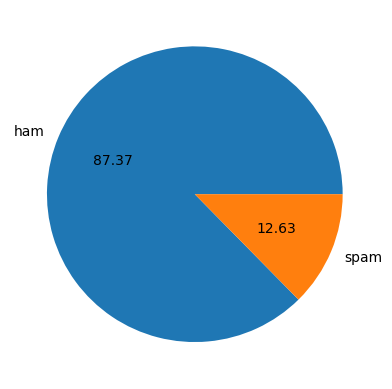

In [35]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')

In [36]:
df['num_characters'] = df['text'].apply(len)

In [38]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [41]:
df['num_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))

In [42]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [43]:
df['num_sent'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

In [44]:
df.head()

,target,text,num_characters,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [49]:
df[['num_characters', 'num_words','num_sent']].describe()

,num_characters,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [51]:
df[df['target']==0][['num_characters', 'num_words','num_sent']].describe()

,num_characters,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [53]:
df[df['target']==1][['num_characters', 'num_words','num_sent']].describe()

,num_characters,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

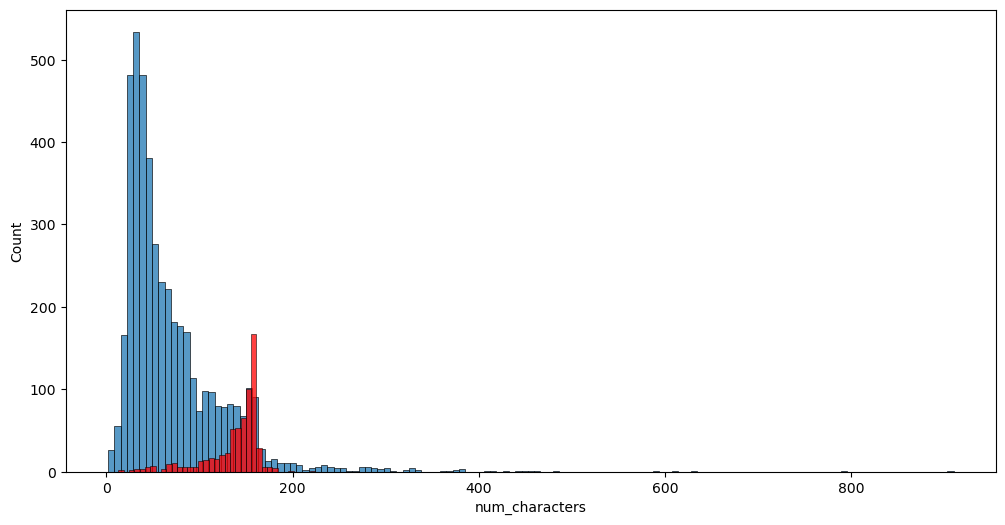

In [55]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target']==0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

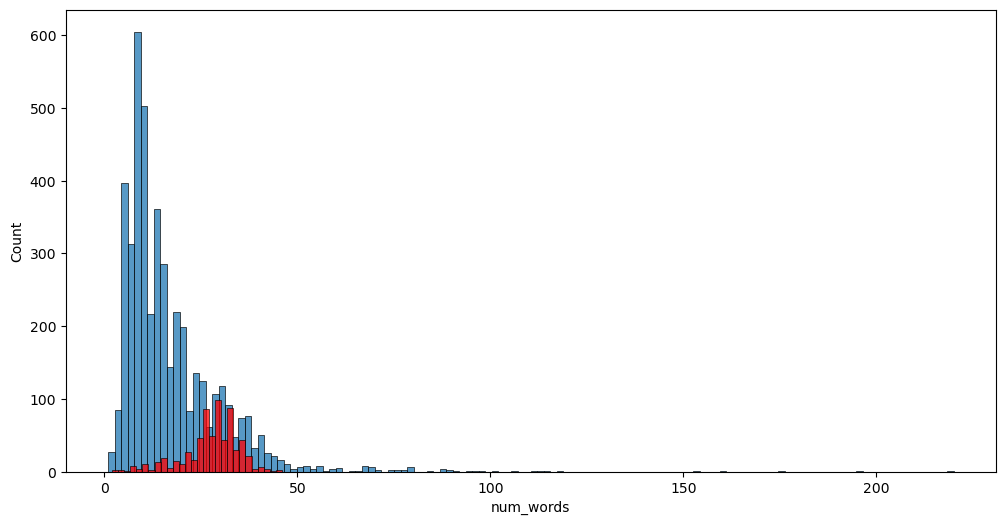

In [56]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

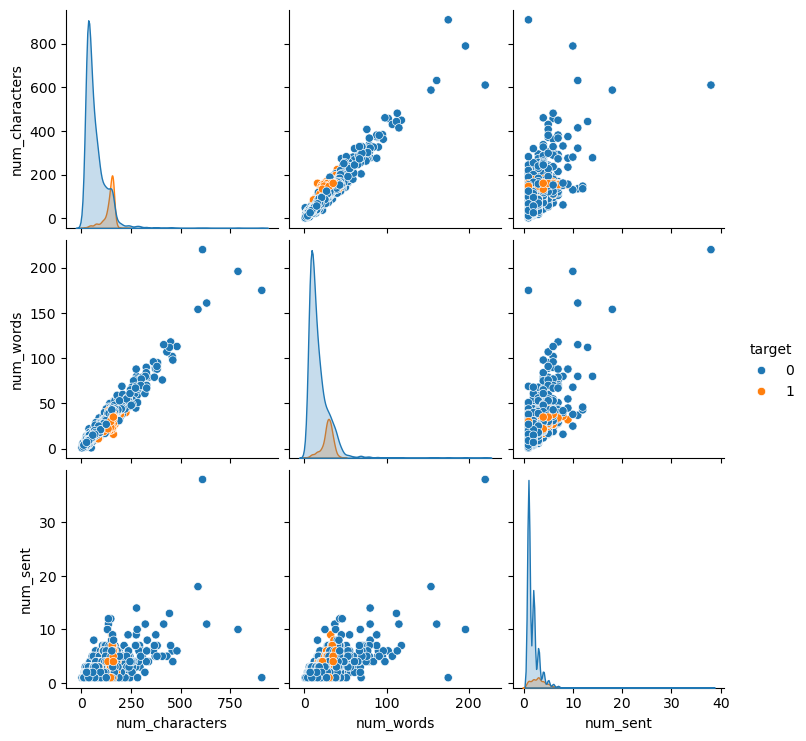

In [58]:
sns.pairplot(hue='target', data=df)

<Axes: >

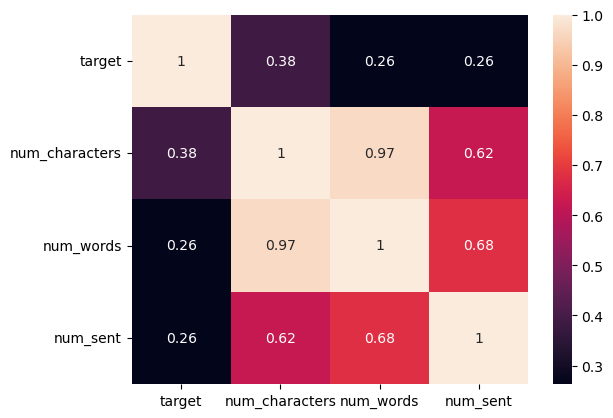

In [59]:
df_numeric = df.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(), annot=True)

## Data Preprocessing
##### 1. lower casing
##### 2. Tokenization
##### 3. Removing Special Characters
##### 4. Removing stopwords and punctuation
##### 5. Stemming

In [62]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def transform_text(text):
    text = text.lower()
    text = word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(stemmer.stem(i))
    text = y[:]
    y.clear()

    for i in text:
        y.append(lemmatizer.lemmatize(i))

    return ' '.join(y)

In [63]:
df['transformed_text'] = df['text'].apply(transform_text)

In [64]:
df.head()

,target,text,num_characters,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [65]:
df['transformed_text'][10]

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [66]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='black')

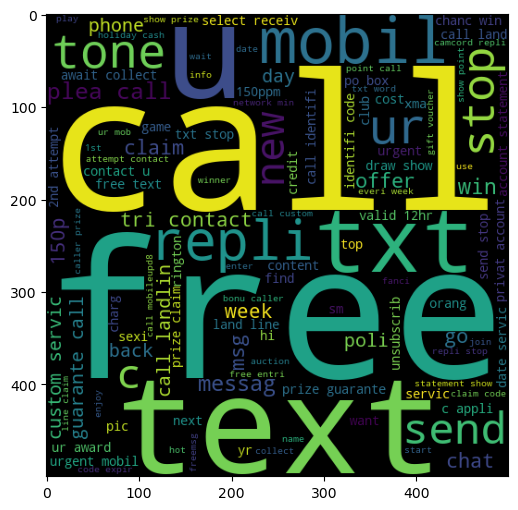

In [67]:
spam_wc = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)

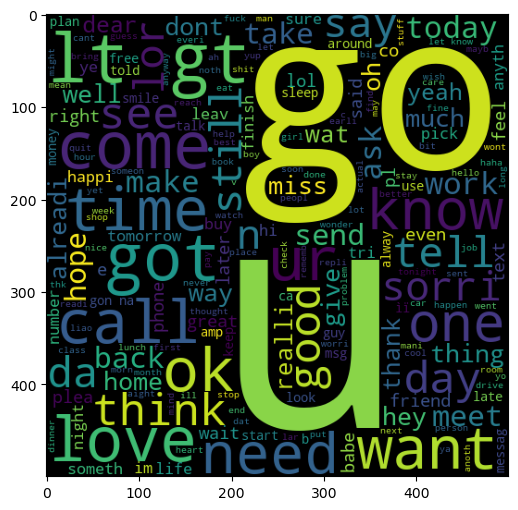

In [68]:
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)

In [69]:
df.head()

,target,text,num_characters,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [70]:
spam_corpus = []
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [71]:
len(spam_corpus)

9939

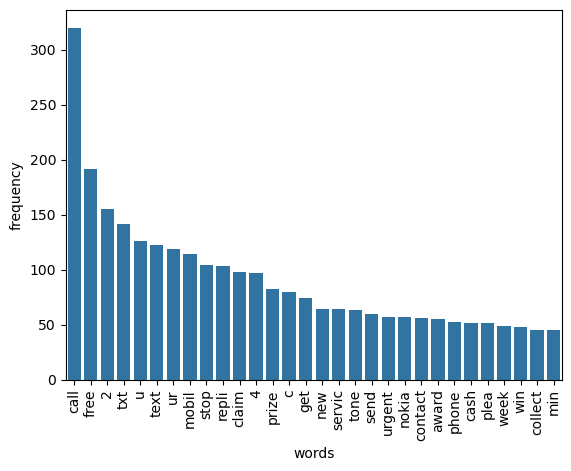

In [73]:
word_counts = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['words', 'frequency'])
sns.barplot(x='words', y='frequency', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()

In [76]:
ham_corpus = []
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [77]:
len(ham_corpus)

35404

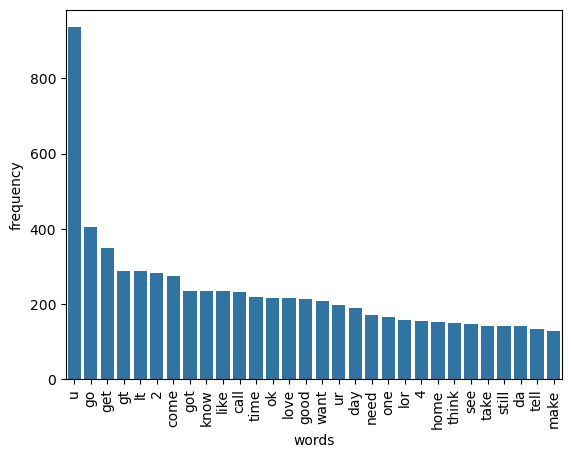

In [78]:
word_counts = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['words', 'frequency'])
sns.barplot(x='words', y='frequency', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()

In [79]:
df.head()

,target,text,num_characters,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [159]:
new_df = df[['transformed_text', 'target']]

In [161]:
new_df.head()

,transformed_text,target
0,go jurong point crazi avail bugi n great world...,0
1,ok lar joke wif u oni,0
2,free entri 2 wkli comp win fa cup final tkt 21...,1
3,u dun say earli hor u c alreadi say,0
4,nah think goe usf live around though,0


In [163]:
x = new_df['transformed_text']
y = new_df['target'].values

In [165]:
x.shape

(5169,)

In [167]:
y.shape

(5169,)

## Model building

In [170]:
tfidf = TfidfVectorizer(max_features=3000)
x = tfidf.fit_transform(x).toarray()

In [172]:
x.shape

(5169, 3000)

In [174]:
y.shape

(5169,)

In [176]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [178]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [180]:
gnb.fit(x_train, y_train)
y_pred1 = gnb.predict(x_test)
print(f'Accuracy Score of GuassianNB: {accuracy_score(y_test, y_pred1)}\n')
print(f'Precision Score of GuassianNB: {precision_score(y_test, y_pred1)}\n')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred1)}')

Accuracy Score of GuassianNB: 0.874274661508704

Precision Score of GuassianNB: 0.5185185185185185

Confusion Matrix:
 [[792 104]
 [ 26 112]]


In [182]:
mnb.fit(x_train, y_train)
y_pred2 = mnb.predict(x_test)
print(f'Accuracy Score of MultinomialNB: {accuracy_score(y_test, y_pred2)}\n')
print(f'Precision Score of MultinomialNB: {precision_score(y_test, y_pred2)}\n')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred2)}')

Accuracy Score of MultinomialNB: 0.9700193423597679

Precision Score of MultinomialNB: 1.0

Confusion Matrix:
 [[896   0]
 [ 31 107]]


In [188]:
bnb.fit(x_train, y_train)
y_pred3 = bnb.predict(x_test)
print(f'Accuracy Score of BernouliNB: {accuracy_score(y_test, y_pred3)}\n')
print(f'Precision Score of BernouliNB: {precision_score(y_test, y_pred3)}\n')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred3)}')

Accuracy Score of BernouliNB: 0.9816247582205029

Precision Score of BernouliNB: 0.9917355371900827

Confusion Matrix:
 [[895   1]
 [ 18 120]]


In [190]:
# Multinomial naive bias give better precision score and accuracy score

In [194]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))